# Redes sociais - P1
Fernando Fincatti, Gabriela Moreno, Gabriella Cukier e Manuel Castanares

---

### Importando bibliotecas
---

In [1]:
import netpixi
from netpixi.data.gt import *
import cpnet
from graph_tool import spectral
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
sns.set()
from matplotlib import rcParams
import statsmodels.formula.api as smf
import csv
import pandas as pd
from graph_tool import util
from graph_tool import Graph
from utils import *
from graph_tool import clustering

### Carrega dados
---

In [2]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [3]:
df.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN


In [4]:
df_noc.head(2)

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles


In [5]:
df_gdp.head(2)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"


In [6]:
#junta ambas as tabelas
df_merge=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge=df_merge.dropna(subset=['region'])

In [7]:
df_merge.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN


### Amostragem
---

In [8]:
#filtra somente datas posteriores a 1970
df_merge=df_merge[df_merge["Year"] > 1970]

### Análise
---

In [9]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [10]:
df_merge['desempenho'] = df_merge['Medal'].apply(lambda x: desempenho(x))

In [11]:
#dropa valores duplicados
df_desempenho = df_merge.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

In [12]:
#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

In [13]:
#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

In [14]:
#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

In [15]:
#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

In [16]:
#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

In [17]:
#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

In [18]:
#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])

In [19]:
df_desempenho_pais.head()

,Sport,region,desempenho,media,Country,GDP ($ per capita)
0,Alpine Skiing,Australia,1,1.857143,Australia,29000.0
1,Alpine Skiing,Austria,3,1.857143,Austria,30000.0
2,Alpine Skiing,Czech Republic,1,1.857143,Czech Republic,15700.0
3,Alpine Skiing,France,2,1.857143,France,27600.0
4,Alpine Skiing,New Zealand,2,1.857143,New Zealand,21600.0


In [20]:
#pega todos os times
lista_teams = df_desempenho_pais.region.unique().tolist()

#pega todos os eventos
lista_eventos = df_desempenho_pais.Sport.unique().tolist()

In [21]:
g.vp['tipo'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')
g.vp['color'] = g.new_vp('object')

In [22]:
lista_vertices = lista_teams+lista_eventos

In [23]:
#cria os times como vértices
cria_vertices(g, lista_vertices, len(lista_teams))
print('número de vértices de g:', g.num_vertices())

número de vértices de g: 148


In [24]:
lista_arestas = list()

#preenche a lista e o dicionario de acordo com as partidas e ocorrencias
df_fake = df_desempenho_pais.apply(lambda x: 
              arestas(x.region, x.Sport, x.desempenho, x.media, lista_arestas),
              axis=1)

In [25]:
create_edgs_links(lista_arestas, g)

### Análise 2
---

In [26]:
c.vp['nome'] = c.new_vp('object') #adiciona propriedade aos vértices
c.ep['peso'] = c.new_ep('object') #adiciona propriedade as arestas

In [27]:
cria_nome_times(g, c) #cria vertíces

In [28]:
dicionario_one_mode, lista_one_mode = lista_esporte_por_time(g)

In [29]:
dist = cria_arestas(c, dicionario_one_mode, lista_one_mode)

### Visualizando grafo C
---

In [30]:
m = draw_gt.sfdp_layout(c)
move_gt(c, m)

In [31]:
save_gt(c, 'exemplo_c.net.gz')

In [32]:
r = netpixi.render('./exemplo_c.net.gz', infinite=True)

### Cluster coefficient
---

In [33]:
cluster = clustering.local_clustering(c)

In [34]:
c.vp['clustering coefficient'] = cluster

In [35]:
dft = pd.DataFrame({k: list(v) for k, v in c.vp.items()})

In [36]:
dft = dft.loc[dft['clustering coefficient'] != 0]

### Salvando grafo e visualizando
---

In [37]:
top = []
for v in g.vertices():
    if g.vp['tipo'][v] == 'time':
        top.append(v)

In [38]:
m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)

In [39]:
save_gt(g, 'exemplo.net.gz')

In [40]:
r = netpixi.render('./exemplo.net.gz')

In [41]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=0, curve2=0)

# mudar uma aresta específica a partir dos ids de sua origem e destino
r.edge(0, 1, color=0x0000ff, width=2)

### Regressão
---

In [42]:
df_desempenho

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes,desempenho
40,16,Juhamatti Tapio Aaltonen,M,28.0,184.0,85.0,Finland,FIN,2014 Winter,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze,Finland,NaN,1
63,20,Kjetil Andr Aamodt,M,22.0,176.0,85.0,Norway,NOR,1994 Winter,1994,Winter,Lillehammer,Alpine Skiing,Alpine Skiing Men's Downhill,Silver,Norway,NaN,2
79,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,Norway,NaN,3
91,29,Willemien Aardenburg,F,22.0,NaN,NaN,Netherlands,NED,1988 Summer,1988,Summer,Seoul,Hockey,Hockey Women's Hockey,Bronze,Netherlands,NaN,1
92,30,Pepijn Aardewijn,M,26.0,189.0,72.0,Netherlands,NED,1996 Summer,1996,Summer,Atlanta,Rowing,Rowing Men's Lightweight Double Sculls,Silver,Netherlands,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247957,124148,Wietse Cornelis van Alten,M,21.0,186.0,72.0,Netherlands,NED,2000 Summer,2000,Summer,Sydney,Archery,Archery Men's Individual,Bronze,Netherlands,NaN,1
248235,124277,Robert Van de Walle,M,26.0,187.0,95.0,Belgium,BEL,1980 Summer,1980,Summer,Moskva,Judo,Judo Men's Half-Heavyweight,Gold,Belgium,NaN,3
254146,127250,Gintar Volungeviit-Scheidt,F,25.0,172.0,63.0,Lithuania,LTU,2008 Summer,2008,Summer,Beijing,Sailing,Sailing Women's One Person Dinghy,Silver,Lithuania,NaN,2
260747,130468,David Robert Wilkins,M,30.0,175.0,75.0,Ireland,IRL,1980 Summer,1980,Summer,Moskva,Sailing,Sailing Mixed Two Person Heavyweight Dinghy,Silver,Ireland,NaN,2


In [43]:
df_desempenho_pais_total = df_desempenho[["region", "desempenho"]].groupby(["region"], as_index=False).sum()

In [44]:
df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")

df_desempenho_pais_total = df_desempenho_pais_total.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")

In [45]:
df_desempenho_pais_total.head()

,region,desempenho,Country,GDP ($ per capita),nome,_x,_y,clustering coefficient
0,Algeria,1,Algeria,6000.0,Algeria,8.193859,14.102007,1.000000
1,Argentina,26,Argentina,11200.0,Argentina,7.853443,11.327483,0.792075
2,Armenia,5,Armenia,3500.0,Armenia,4.901594,7.226101,1.000000
3,Australia,82,Australia,29000.0,Australia,5.464733,12.893998,0.679000
4,Austria,25,Austria,30000.0,Austria,3.230121,13.923680,0.874191


In [46]:
df_desempenho_pais_total

,region,desempenho,Country,GDP ($ per capita),nome,_x,_y,clustering coefficient
0,Algeria,1,Algeria,6000.0,Algeria,8.193859,14.102007,1.000000
1,Argentina,26,Argentina,11200.0,Argentina,7.853443,11.327483,0.792075
2,Armenia,5,Armenia,3500.0,Armenia,4.901594,7.226101,1.000000
3,Australia,82,Australia,29000.0,Australia,5.464733,12.893998,0.679000
4,Austria,25,Austria,30000.0,Austria,3.230121,13.923680,0.874191
...,...,...,...,...,...,...,...,...
96,Uzbekistan,8,Uzbekistan,1700.0,Uzbekistan,7.709241,9.631863,0.936408
97,Venezuela,2,Venezuela,4800.0,Venezuela,8.697462,11.001144,0.906642
98,Vietnam,5,Vietnam,2500.0,Vietnam,2.193208,8.354468,0.871795
99,Zambia,2,Zambia,800.0,Zambia,-0.763838,13.066751,1.000000


In [47]:
df_desempenho_pais_total['y'] = df_desempenho_pais_total['GDP ($ per capita)']
df_desempenho_pais_total['c'] = df_desempenho_pais_total['clustering coefficient']

In [48]:
model = smf.ols(data=df_desempenho_pais_total, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     17.99
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           5.33e-05
Time:                        00:21:51   Log-Likelihood:                -459.55
No. Observations:                  93   AIC:                             923.1
Df Residuals:                      91   BIC:                             928.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1337      5.308      1.344      0.182      -3.410      17.678
y              0.0015      0.000      4.241      0.000       0.001       0.002
==============================================================================
Omnibus:                      112.319   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2196.977
Skew:                           3.948   Prob(JB):                         0.00
Kurtosis:                      25.464   Cond. No.                     2.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

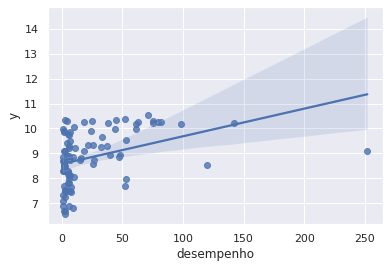

In [49]:
sns.regplot(x=df_desempenho_pais_total['desempenho'], y=np.log(df_desempenho_pais_total['y']))
plt.show()

### Conclusão
---

Com base na regressão feita acima, podemos ver que o coeficiente é muito pequeno. O $R^2$ obtido também é muito pequeno, mostrando que não há um bom fit entre as duas variáveis. Além disso, os valores para o eixo X (desempenho) também são muito parecidos, o que faz o gráfico ficar "empilhado", isso é possível confirmar apartir da visualização acima. Portanto podemos rejeitar a hipótese de que mais riqueza signifca mais desempenho.

## Clustering Coefficient X Desempenho

In [50]:
df_desempenho_cluster = df_desempenho_pais_total.dropna(subset=['clustering coefficient'])

In [51]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     104.2
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           1.34e-16
Time:                        00:21:52   Log-Likelihood:                -418.58
No. Observations:                  90   AIC:                             841.2
Df Residuals:                      88   BIC:                             846.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    202.6792     17.649     11.484      0.000     167.606     237.752
c           -207.2944     20.306    -10.208      0.000    -247.648    -166.940
==============================================================================
Omnibus:                       93.926   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1550.754
Skew:                           3.129   Prob(JB):                         0.00
Kurtosis:                      22.349   Cond. No.                         13.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

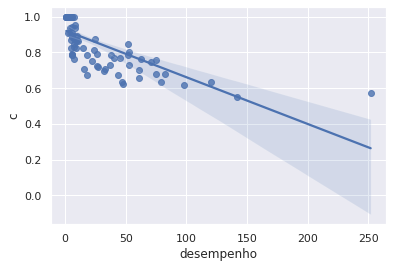

In [52]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

### Análise com variáveis de controle

#### Desempenho X (Clustering Coefficient + GDP)

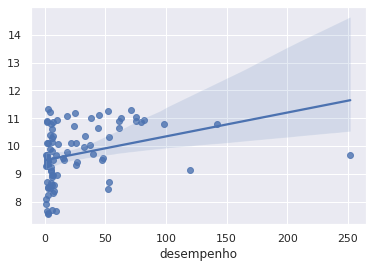

In [54]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=(df_desempenho_cluster['c'] + np.log(df_desempenho_cluster['y'])))
plt.show()

In [55]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ y+c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     55.72
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           2.64e-16
Time:                        00:22:26   Log-Likelihood:                -416.63
No. Observations:                  90   AIC:                             839.3
Df Residuals:                      87   BIC:                             846.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    182.4141     20.207      9.027      0.000     142.250     222.578
y              0.0006      0.000      1.962      0.053   -7.15e-06       0.001
c           -191.0017     21.641     -8.826      0.000    -234.015    -147.988
==============================================================================
Omnibus:                      109.396   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2507.037
Skew:                           3.816   Prob(JB):                         0.00
Kurtosis:                      27.704   Cond. No.                     1.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Filtragem

In [61]:
df_desempenho_pais_total[df_desempenho_pais_total['desempenho']>100]


,region,desempenho,Country,GDP ($ per capita),nome,_x,_y,clustering coefficient,y,c
14,China,120,China,5000.0,China,6.015366,10.161933,0.635322,5000.0,0.635322
29,Germany,142,Germany,27600.0,Germany,4.786579,11.772248,0.551660,27600.0,0.551660
75,Russia,252,Russia,8900.0,Russia,4.880919,11.040391,0.571917,8900.0,0.571917
93,USA,198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df_desempenho_pais_filtered = df_desempenho_pais_total[df_desempenho_pais_total['desempenho']<100]

In [64]:
df_desempenho_cluster = df_desempenho_pais_filtered.dropna(subset=['clustering coefficient'])

In [65]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     136.5
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           2.29e-19
Time:                        00:27:21   Log-Likelihood:                -357.59
No. Observations:                  87   AIC:                             719.2
Df Residuals:                      85   BIC:                             724.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    149.5443     11.239     13.306      0.000     127.199     171.890
c           -149.6822     12.812    -11.683      0.000    -175.155    -124.210
==============================================================================
Omnibus:                        5.512   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                4.792
Skew:                           0.496   Prob(JB):                       0.0911
Kurtosis:                       3.581   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

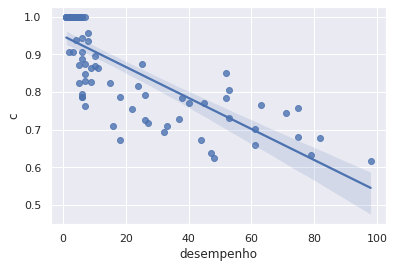

In [66]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()